In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown

%matplotlib inline

In [2]:
os.listdir('.')

['.gitignore',
 '.ipynb_checkpoints',
 'chicago_crimes_eda.ipynb',
 'README.md',
 'Chicago_crimes.csv',
 '.git',
 'fbi_codes.csv']

In [3]:
df = pd.read_csv('Chicago_crimes.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Updated On'] = pd.to_datetime(df['Updated On'], format='%m/%d/%Y %I:%M:%S %p')
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,...,28.0,25.0,04B,1144606.0,1903566.0,2015,2018-02-10 15:50:01,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,...,15.0,67.0,26,1166468.0,1860715.0,2015,2018-02-10 15:50:01,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,4.0,39.0,08B,1185075.0,1875622.0,2015,2018-02-10 15:50:01,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,2015-03-18 22:30:00,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,...,3.0,40.0,08B,1178033.0,1870804.0,2015,2018-02-10 15:50:01,41.800802,-87.622619,"(41.800802415, -87.622619343)"
4,10000097,HY189976,2015-03-18 21:00:00,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,...,28.0,25.0,03,1144920.0,1898709.0,2015,2018-02-10 15:50:01,41.878065,-87.743354,"(41.878064761, -87.743354013)"


In [4]:
df.dtypes

ID                               int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                             int64
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On              datetime64[ns]
Latitude                       float64
Longitude                      float64
Location                        object
dtype: object

In [5]:
# remove unuseful columns and drop NaN it's about 10% of dataset
df.drop(['Case Number', 'Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
df.dropna(how='any', inplace=True)

In [6]:
df['Month'] = df['Date'].dt.month.astype('uint8')
df['Weekday'] = df['Date'].dt.weekday.astype('uint8')
df['Day'] = df['Date'].dt.day.astype('uint8')
# Block without house number
df['Only Block'] = df['Block'].str.extract('[0-9|X]* (.*)', expand=False)
df.drop(['Block'], axis=1, inplace=True)

df['Day_diff'] = df['Updated On'] - df['Date']
df['Day_diff'] = df['Day_diff'].dt.days
df['Day_diff'] = df['Day_diff'].astype('uint16')

In [7]:
# Fill unknown values and convert to less consumin datatype
dtypes = {'ID': 'uint32', 'Beat': 'uint16', 'Year': 'uint16', 'District': 'uint8', 'Ward': 'uint8', 
          'Community Area': 'uint8'}
for key, value in dtypes.items():
    df[key] = df[key].astype(value)

In [8]:
# Dataframe to map column 'FBI Code' and human readable description
if 'fbi_codes.csv' not in os.listdir('.'):
    fbi_df = pd.DataFrame({'Code': [], 'Description': [], 'Serious offense': []})
    temp = pd.read_html('http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html')
    # pattern that retrive desription and code
    pattern = re.compile(r' ([\w& -]*) (\(\d{2}[A-Z]?\))')
    # Retrive information about National Incident-Based Reporting System (NIBRS) codes
    # Crimes classified to less or more serious
    for i, serious_offense in enumerate([True, False]): 
        fbi_str = temp[0].iloc[3+i][1].replace('\xa0', ' ').replace('  ', ' ')
        fbi_list = pattern.findall(fbi_str)
        for desc, code in fbi_list:
            fbi_df = fbi_df.append(pd.DataFrame({'Code': [code[1:-1]], 'Description': [desc], 
                                                 'Serious offense': [serious_offense]}), ignore_index=True)
    fbi_df['Serious offense'] = fbi_df['Serious offense'].astype('bool')
    fbi_df.to_csv('fbi_codes.csv', index=False)
else:
    fbi_df = pd.read_csv('fbi_codes.csv', dtype={'Serious offense': 'bool'})

# Map of Chicago

In [9]:
# use for ignoring errors in coordinates
df['Longitude'].mean(), df['Longitude'].std(), df['Latitude'].mean(), df['Latitude'].std()

(-87.67183667212996,
 0.061425410282025014,
 41.84156879021282,
 0.08915885683457035)

In [10]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

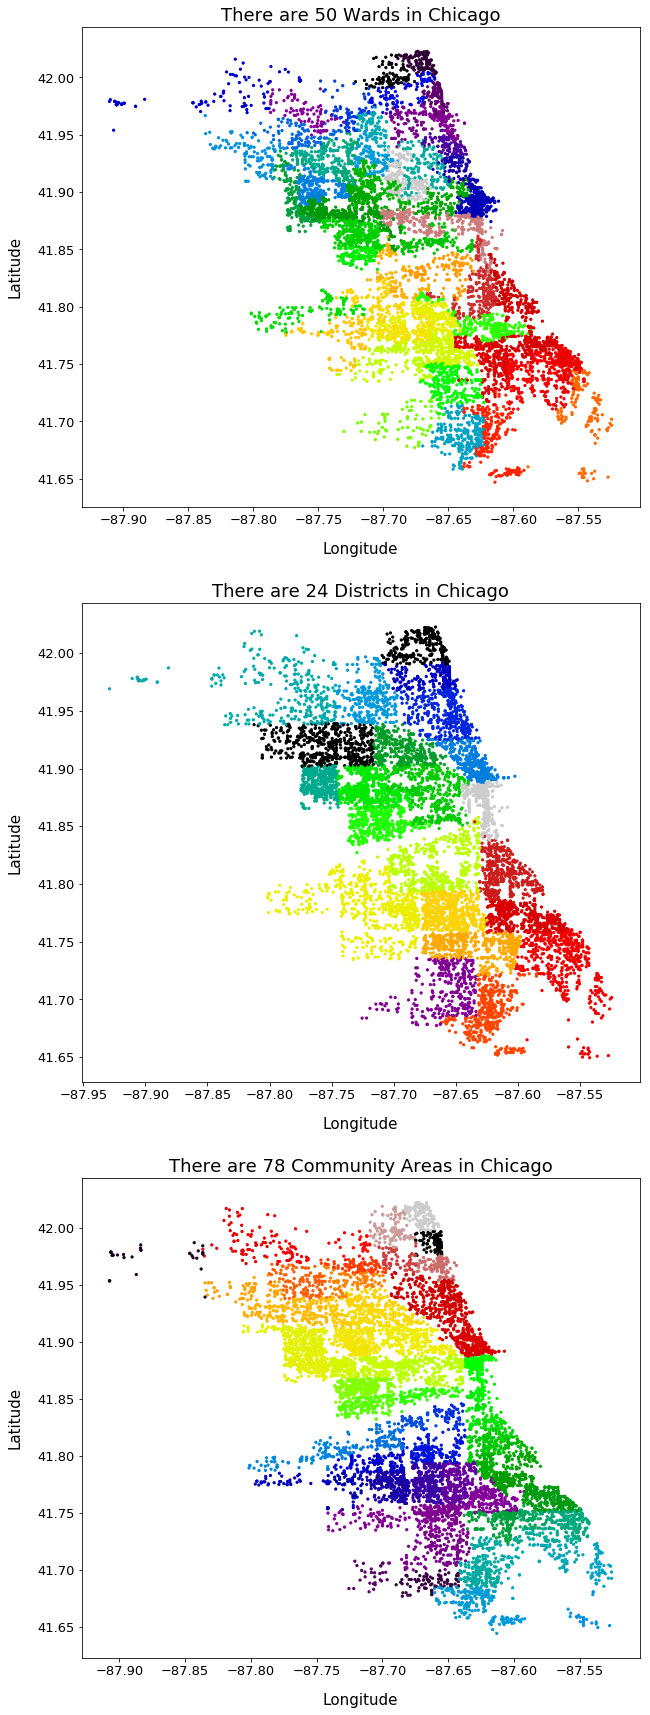

In [11]:
temp_list = ['Ward', 'District', 'Community Area']
fig, ax = plt.subplots(len(temp_list), 1)
n = 10
fig.set_figheight(n * len(temp_list))
fig.set_figwidth(n)

for i, column in enumerate(temp_list):
    temp = df[['Latitude', 'Longitude', column]].copy()

    # removing some anomalies
    temp = temp.loc[temp['Longitude'].between(-90, -85) & temp['Latitude'].between(39, 43), :]
    temp = temp.sample(10000)
    
    ax[i].scatter(temp['Longitude'], temp['Latitude'], c=temp[column], s=5, 
                cmap=discrete_cmap(df[column].nunique(), 'nipy_spectral_r'))
    ax[i].set_title('There are {} {}s in Chicago'.format(df[column].nunique(), temp_list[i]), 
                    fontdict={'fontsize': 18})
    ax[i].set_xlabel('Longitude', size=15, labelpad=15)
    ax[i].set_ylabel('Latitude', size=15, labelpad=15)
    ax[i].tick_params(labelsize=13)

In [12]:
temp = df['FBI Code'].value_counts().reset_index().merge(fbi_df, left_on='index', right_on='Code')\
.rename(columns={'FBI Code': 'counts'}).drop(['Code', 'index'], axis=1)
temp['pct'] = temp['counts'] / temp['counts'].sum()

# create color dict
colrs = (plt.cm.tab20.colors + plt.cm.tab20c.colors)[:temp['Description'].shape[0]]
colrs = dict(zip(temp['Description'], colrs))

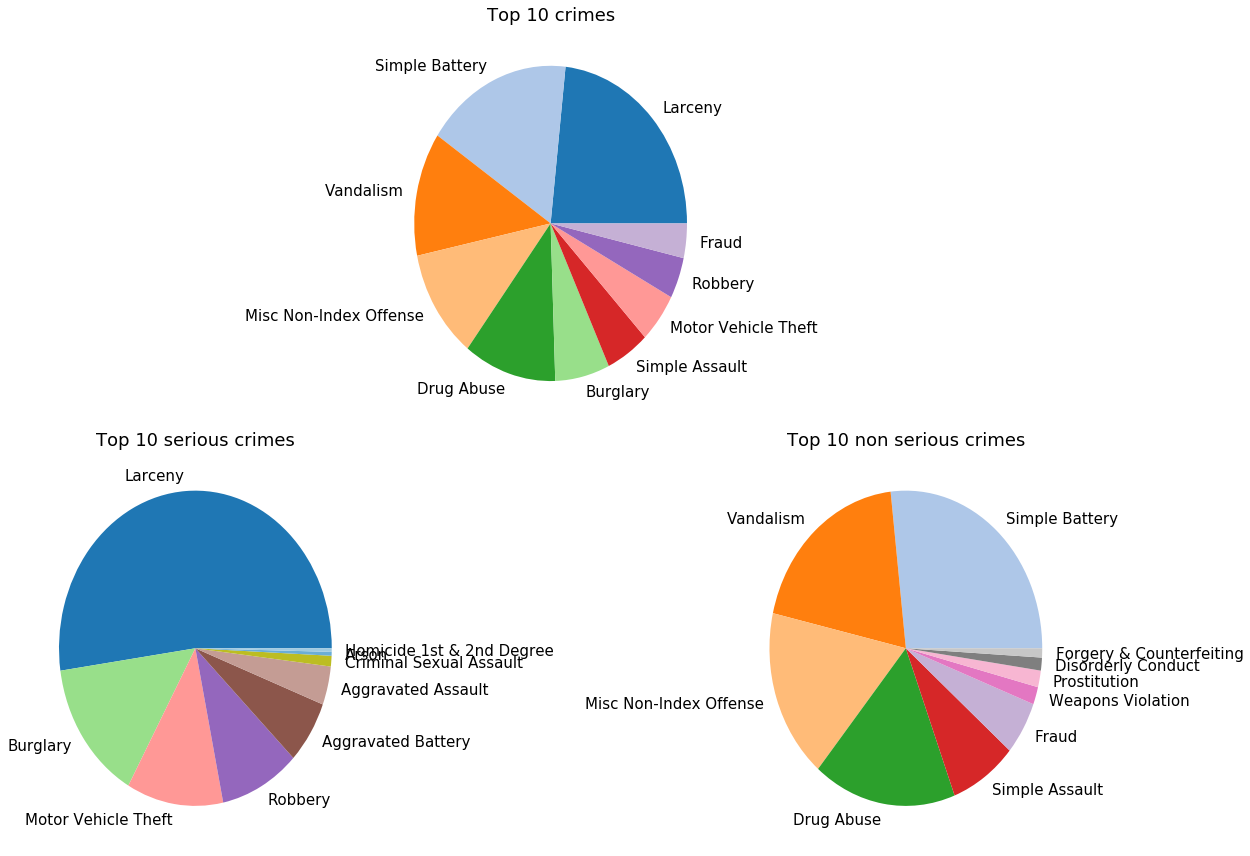

In [13]:
fig = plt.figure(figsize=(15, 12))

ax1 = plt.subplot2grid((2, 3), (0, 1))
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (1, 2))

titles = ['Top 10 crimes', 'Top 10 serious crimes', 'Top 10 non serious crimes']


for i, ax in enumerate([ax1, ax2, ax3]):
    if i == 0:
        _temp = temp.sort_values('counts', ascending=False).head(10)
    if i == 1:    
        _temp = temp.loc[temp['Serious offense'] == True].sort_values('counts', ascending=False).head(10)
    if i == 2:
        _temp = temp.loc[temp['Serious offense'] == False].sort_values('counts', ascending=False).head(10)
    
    
    wedges, texts = ax.pie(x=_temp['counts'], labels=_temp['Description'],
                            colors=[colrs[label] for label in _temp['Description']])
    
    [text.set_size(15) for text in texts]
    ax.set_title(titles[i], fontdict={'fontsize': 18})

plt.tight_layout()
del _temp

In [14]:
# Location Description for whole years, 2003 and 2017
temp = df.loc[df['Year'] == 2003, 'Location Description'].value_counts()
temp = temp * 100 / temp.sum()
in_2003 = temp.reset_index().rename(columns={'index': 'Location', 'Location Description': 'pct_2003'})
in_2003['pct_2003'] = in_2003['pct_2003'].apply(round, args=(1,))

temp = df.loc[df['Year'] == 2017, 'Location Description'].value_counts()
temp = temp * 100 / temp.sum()
in_2017 = temp.reset_index().rename(columns={'index': 'Location', 'Location Description': 'pct_2017'})
in_2017['pct_2017'] = in_2017['pct_2017'].apply(round, args=(1,))

temp = df['Location Description'].value_counts()
temp = temp * 100 / temp.sum()
temp = temp.reset_index().rename(columns={'index': 'Location', 'Location Description': 'pct_total'})
temp['pct_total'] = temp['pct_total'].apply(round, args=(1,))
temp.merge(in_2003, how='left', left_on='Location', right_on='Location')\
.merge(in_2017, how='left', left_on='Location', right_on='Location').head(10)

,Location,pct_total,pct_2003,pct_2017
0,STREET,25.9,30.7,22.6
1,RESIDENCE,16.6,17.1,17.0
2,APARTMENT,10.8,8.3,12.5
3,SIDEWALK,10.3,7.9,7.9
4,OTHER,3.7,3.8,4.2
5,PARKING LOT/GARAGE(NON.RESID.),2.8,3.0,3.1
6,ALLEY,2.3,2.3,2.0
7,"SCHOOL, PUBLIC, BUILDING",2.1,2.5,1.3
8,RESIDENCE-GARAGE,2.0,2.1,1.7
9,SMALL RETAIL STORE,1.8,1.6,2.6


### During years location of incident changed. Amount of incidents on streets decreased, but increased in apartments. In other location amount of incident is pretty constant.

In [15]:
temp = df.groupby(by=['FBI Code'])['Arrest'].mean().reset_index()\
.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Description', 'Arrest']]
temp = temp.sort_values(by='Arrest')
temp = temp.append({'Description': 'Overall', 'Arrest': df['Arrest'].mean()}, ignore_index=True)

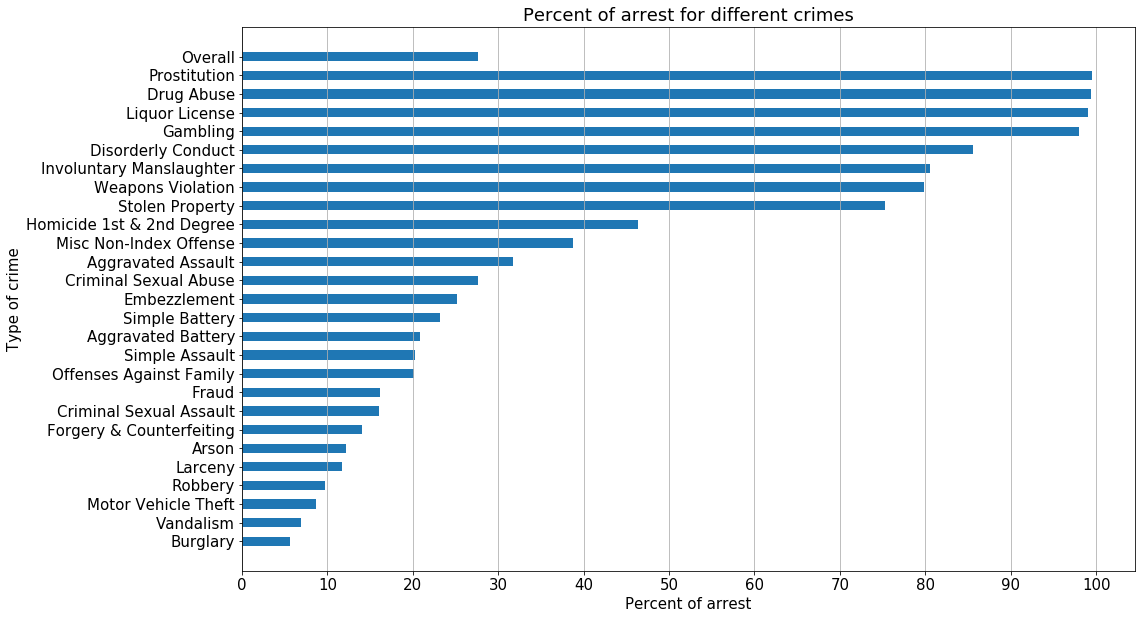

In [16]:
fig = plt.figure(figsize=(16, 10))

plt.barh(y=range(temp.shape[0]), width=temp['Arrest'] * 100, height=0.5, tick_label=temp['Description'])

ax = fig.get_axes()[0]
ax.set_title('Percent of arrest for different crimes', size=18)
ax.xaxis.grid(True)
ax.set_xlabel('Percent of arrest', size=15)
ax.set_ylabel('Type of crime', size=15)
ax.set_xticks([i for i in range(0, 110, 10)])
plt.setp(ax.get_xticklabels(), size=15)
plt.setp(ax.get_yticklabels(), size=15);

In [17]:
temp = df.groupby(by=['FBI Code'])['Domestic'].mean().reset_index()\
.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Description', 'Domestic']]
temp = temp.sort_values(by='Domestic')
temp = temp.append({'Description': 'Overall', 'Domestic': df['Domestic'].mean()}, ignore_index=True)

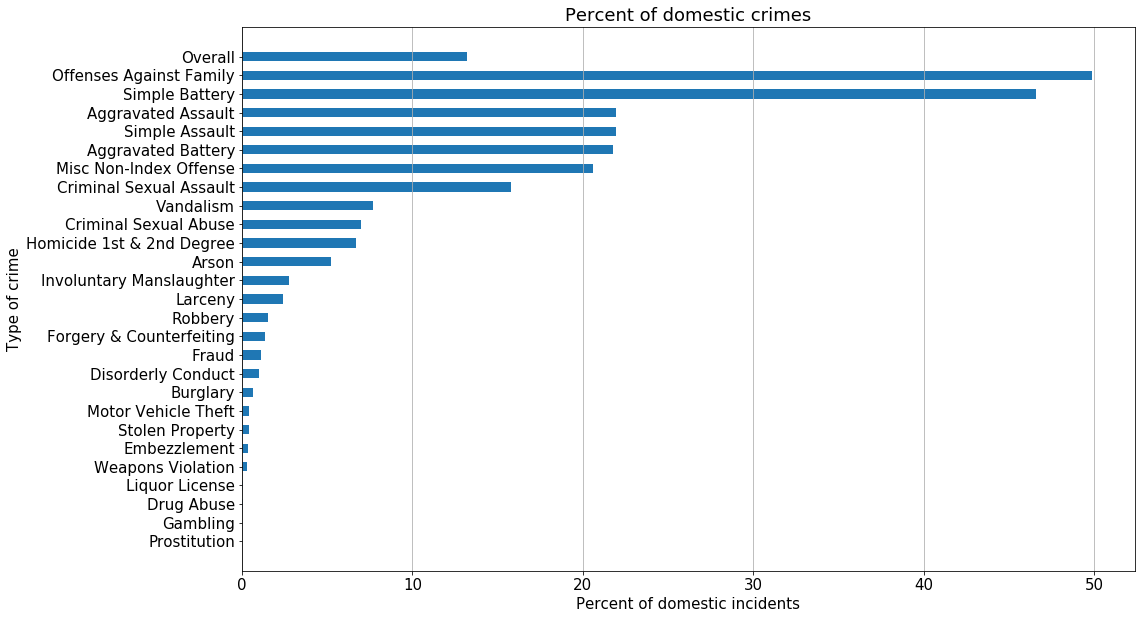

In [18]:
fig = plt.figure(figsize=(16, 10))

plt.barh(y=range(temp.shape[0]), width=temp['Domestic'] * 100, height=0.5, tick_label=temp['Description'])

ax = fig.get_axes()[0]
ax.set_title('Percent of domestic crimes', size=18)
ax.xaxis.grid(True)
ax.set_xlabel('Percent of domestic incidents', size=15)
ax.set_ylabel('Type of crime', size=15)
ax.set_xticks([i for i in range(0, 60, 10)])
plt.setp(ax.get_xticklabels(), size=15)
plt.setp(ax.get_yticklabels(), size=15);

### Most of incident isn't a domestic ones. Only 'Offenses Against Family' and 'Simple Battery' frequntly happen at home. Overall domestic incidents is only 13%.

In [19]:
# Count for Community Area
temp = df.groupby(by=['Community Area'])['ID'].count().reset_index()
temp['pct'] = temp['ID'] * 100 / temp['ID'].sum()

# Find mean longitude and latitude for every area
com_cor = df.groupby(by=['Community Area'])[['Longitude', 'Latitude']].mean().reset_index()
com_cor = temp.merge(com_cor).sort_values(by='ID', ascending=False).reset_index()

temp = df.merge(fbi_df, left_on='FBI Code', right_on='Code') [['Community Area', 'Serious offense', 'ID']]
temp = temp.groupby(by=['Community Area']).agg({'Serious offense': 'mean', 'ID': 'count'}).reset_index()
temp['Ser_pct'] = temp['Serious offense'] * 100

com_cor = com_cor.merge(temp)

In [20]:
# Count for street
temp = df.groupby(by=['Only Block'])['ID'].count().reset_index().sort_values(by='ID', ascending=False)
arr_most_crime = temp['Only Block'].head(50).values
temp['pct'] = temp['ID'] * 100 / temp['ID'].sum()
temp.head(5)

,Only Block,ID,pct
1762,S STATE ST,69042,1.154401
1634,S MICHIGAN AVE,61146,1.022378
2661,W MADISON ST,54608,0.913061
1451,S HALSTED ST,54260,0.907242
1179,S ASHLAND AVE,53849,0.900370


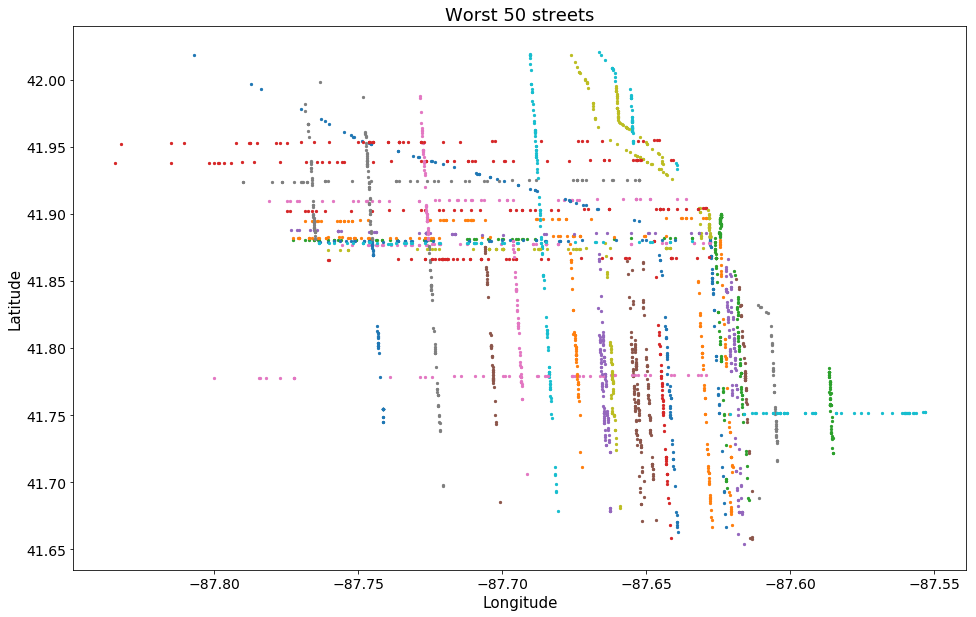

In [21]:
fig = plt.figure(figsize=(16, 10))

_temp = df.loc[(df['Longitude'].between(-90, -85) & df['Latitude'].between(39, 43)), 
               ['Longitude', 'Latitude', 'Only Block']].copy()
               
for street in arr_most_crime:
    sam = _temp.loc[_temp['Only Block'] == street, ['Longitude', 'Latitude']].sample(50)
    plt.scatter(sam['Longitude'], sam['Latitude'], s=5)
    
plt.title('Worst 50 streets', size=18)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
del _temp

### Almost all of them are long streets

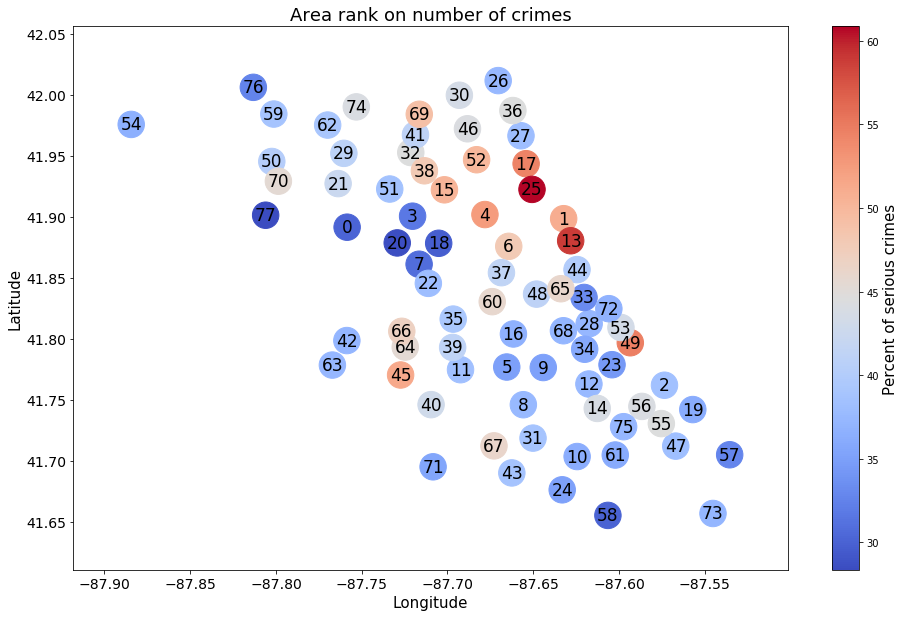

In [22]:
fig = plt.figure(figsize=(16, 10))

plt.scatter(com_cor['Longitude'], com_cor['Latitude'], s=700, 
            c=com_cor['Ser_pct'], cmap='coolwarm')
cbar = plt.colorbar()
cbar.ax.set_ylabel(ylabel='Percent of serious crimes', size=15)

for row_number, row in com_cor.iterrows():
    plt.text(row['Longitude'], row['Latitude'], s=row_number, ha='center', va='center', color='k', size=17)

plt.title('Area rank on number of crimes', size=18)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14);

### Area rank isn't strongly correlated with percent of serious crimes

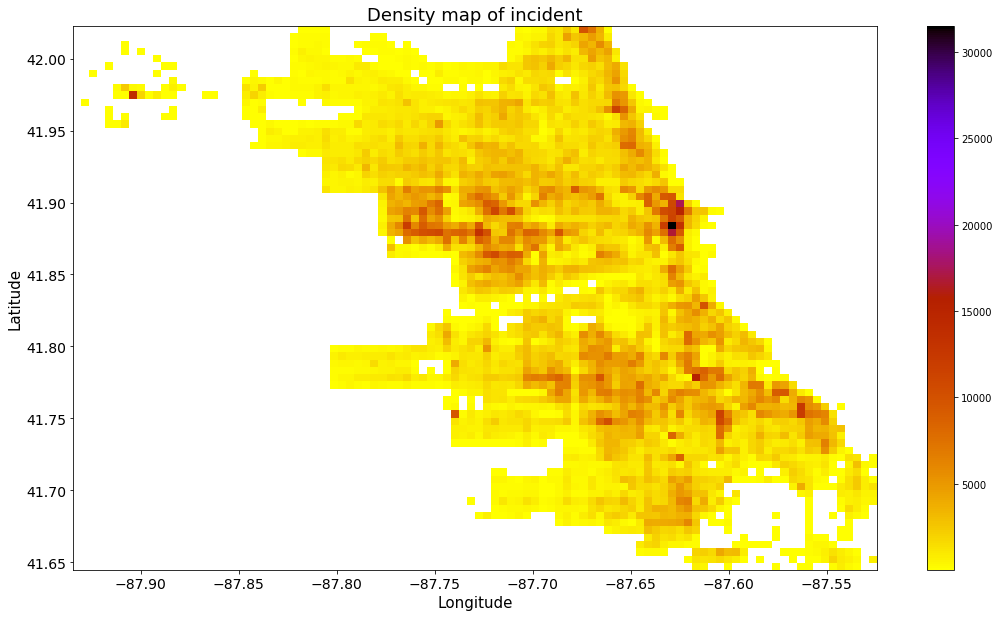

In [23]:
fig = plt.figure(figsize=(18, 10))

temp = df.loc[(df['Longitude'].between(-90, -85) & df['Latitude'].between(39, 43)), 
               ['Longitude', 'Latitude']].copy()

h, x, y, a = plt.hist2d(temp['Longitude'].dropna(), temp['Latitude'].dropna(), cmin=10, 
                        bins=(100, 75), cmap='gnuplot_r')
plt.colorbar()
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Density map of incident', fontsize=18);

### There is some especially bad place 

In [24]:
# fill nan
h = np.nan_to_num(h)
# find max value
first_max = np.unravel_index(h.argmax(), h.shape)
h[first_max]

31483.0

In [25]:
# incident around worst point on map
temp = df.loc[(df['Longitude'].between(x[first_max[0]-1], x[first_max[0]+1]) \
               & df['Latitude'].between(y[first_max[1]-1], y[first_max[1]+1]))].copy()
temp = temp.merge(fbi_df, left_on='FBI Code', right_on='Code')
temp.shape

(67567, 25)

In [26]:
# Much bigger than averege in the city
temp['Serious offense'].mean()

0.6077227048707209

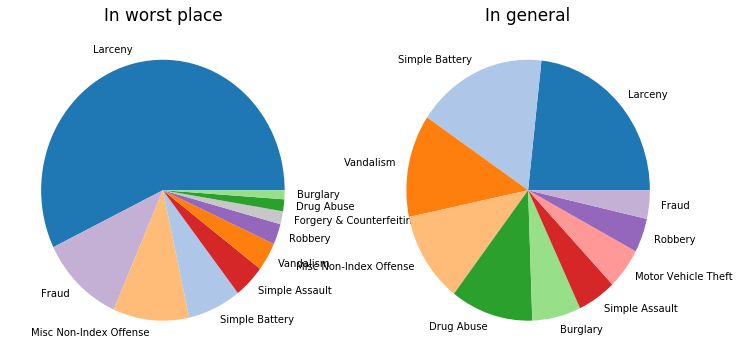

In [27]:
general = df.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Year', 'Description_y', 'ID']]
general = general.groupby('Description_y')['ID'].count().reset_index().sort_values('ID', ascending=False)
worst_palce = temp.groupby('Description_y')['ID'].count().reset_index().sort_values('ID', ascending=False)

# lot top 10
general = general.head(10)
worst_palce = worst_palce.head(10)
plt.pie
fig, ax = plt.subplots(1, 2, figsize=(2*6, 6))
ax[0].pie(x=worst_palce['ID'], labels=worst_palce['Description_y'], 
          colors=[colrs[label] for label in worst_palce['Description_y']])
ax[0].set_title('In worst place', size=17)

ax[1].pie(x=general['ID'], labels=general['Description_y'], 
          colors=[colrs[label] for label in general['Description_y']])
ax[1].set_title('In general', size=17);

### There are much more larceny incidents in worst place in Chicago.

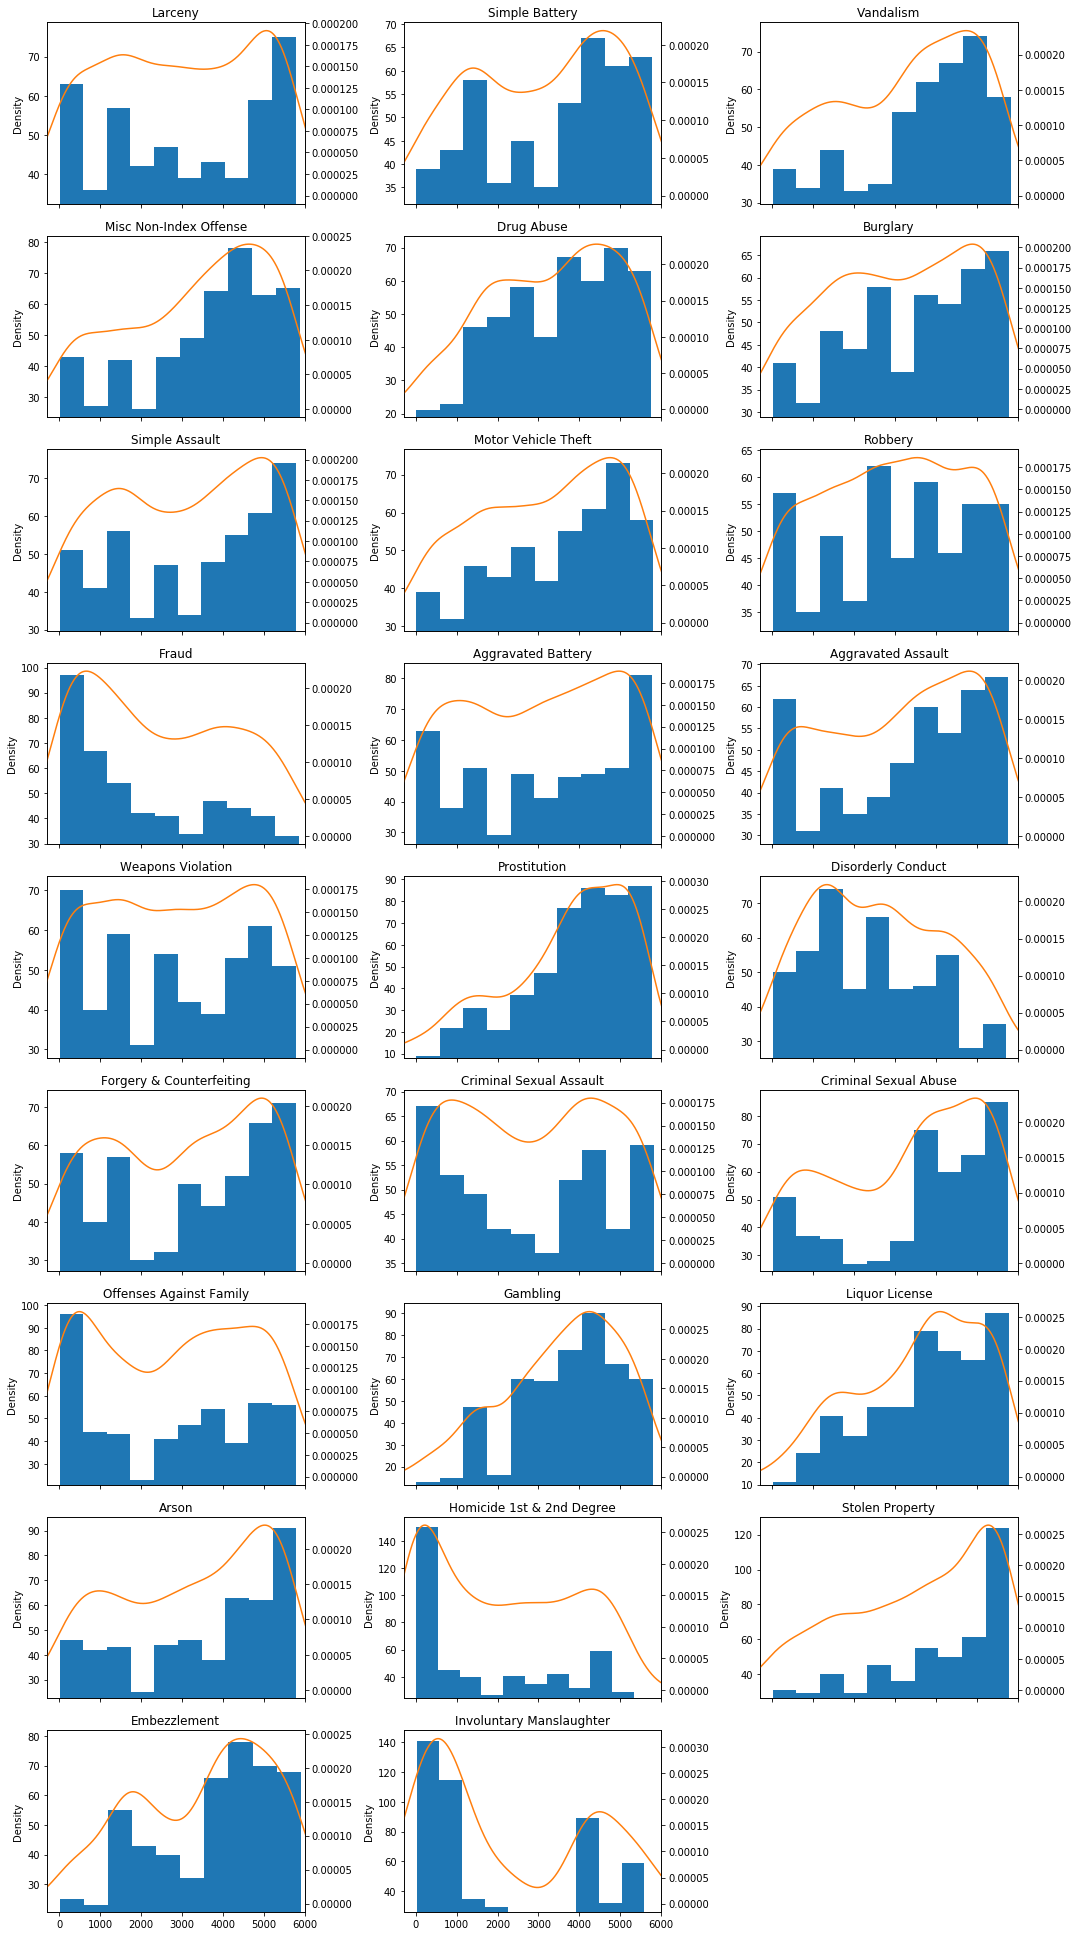

In [28]:
# list of incidents, sorted by their frequentist
l = df['FBI Code'].value_counts().reset_index()['index']

n = 3 # col
m = (len(l) - 1) // n + 1 # rows
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3), sharex=False)

for i, code in enumerate(l):
    r, c = i // n, i % n
    ax = axes[r, c]
    
    temp = df.loc[df['FBI Code'] == code, 'Day_diff'].sample(500, replace=True)
    arr, bins, pathes = ax.hist(x=temp, bins=10)
    ax.set_xlim(-300, 6000)
    ax.set_ylim(arr[arr != 0].min() * 0.9)
    ax2 = temp.plot.kde(ax=ax, secondary_y=True, title=fbi_df.loc[fbi_df['Code'] == code, 'Description'].values[0])

# hide last box
axes[-1, -1].axis('off')

fig.tight_layout()

### The distributions of days from incident till last update are different, but mostly are left skewed. It means that information about lots of incident was updated after long period of time. Perhaps it's done to follow some standard. A lot of crimes have a peak in the beginning. It can be assumed that such crimes was solved fast.

In [29]:
df['Updated On'].dt.dayofyear.value_counts().reset_index()\
.rename(columns={'index': 'Day of year', 'Updated On': 'counts'}).head()

,Day of year,counts
0,41,2762951
1,59,2670272
2,35,345150
3,124,85761
4,45,18757


In [30]:
df['Updated On'].dt.day.value_counts().reset_index()\
.rename(columns={'index': 'Day of month', 'Updated On': 'counts'}).head()

,Day of month,counts
0,10,2765903
1,28,2671944
2,4,432843
3,14,21582
4,17,19888


### Almost all change made on 10 or 28 of February. This is most likely end of reporting year for the police.

In [31]:
temp = df.groupby(by='Year')['ID'].count().reset_index()

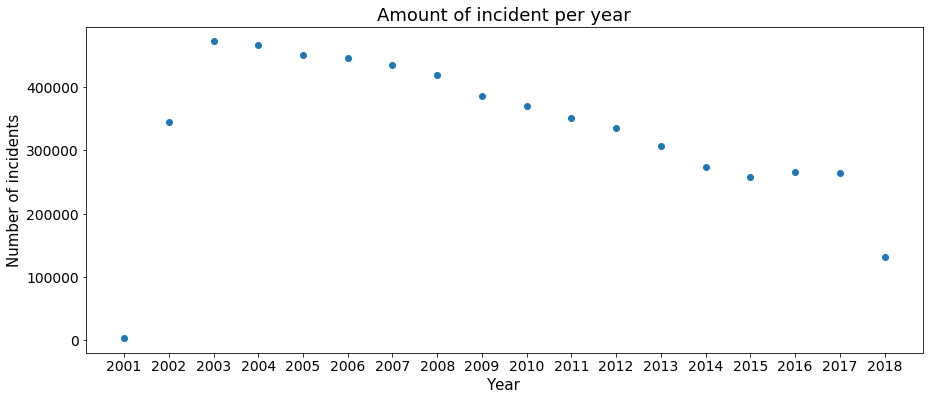

In [32]:
fig = plt.figure(figsize=(15, 6))
plt.scatter(x=temp['Year'], y=temp['ID'])

plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of incidents', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(range(2001, 2019, 1), fontsize=14)
plt.title('Amount of incident per year', fontsize=18);

### Most likely that information of incident in 2001, 2002 and 2018 is not full. The amount of incident is going down steady and from 2003 to 2017 and  decreased for about 55%. There is slight increasement in amount of incident in 2016 and 2017. So graph has saturation in the end, hard to say will it be a new trend or it will start going down again.

In [33]:
temp = df.groupby(by='Month')['ID'].count().reset_index()

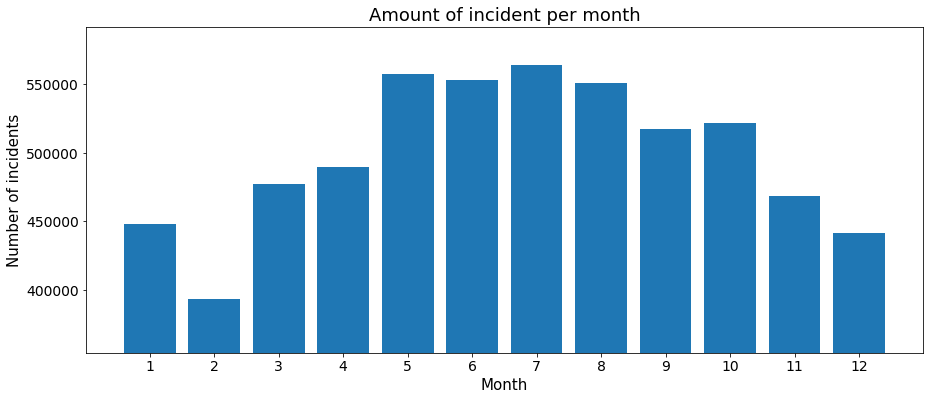

In [34]:
fig = plt.figure(figsize=(15, 6))
plt.bar(x=range(1, 13, 1), height=temp['ID'], width=0.8, align='center')
plt.ylim(temp['ID'].min() * 0.9)

plt.xlabel('Month', fontsize=15)
plt.ylabel('Number of incidents', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(range(1, 13, 1), fontsize=14)
plt.title('Amount of incident per month', fontsize=18);

### This is consistent with the statistics for the country

In [35]:
temp = df.groupby(by='Weekday')['ID'].count().reset_index()

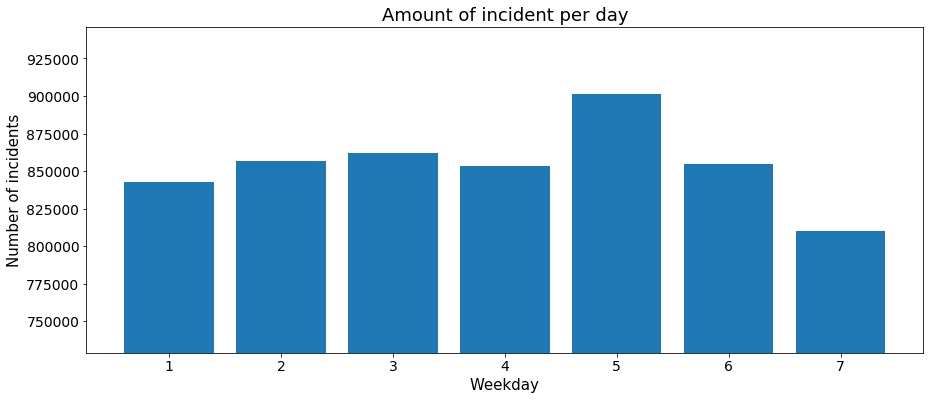

In [36]:
fig = plt.figure(figsize=(15, 6))
plt.bar(x=range(1, 8, 1), height=temp['ID'], width=0.8, align='center')
plt.ylim(temp['ID'].min() * 0.9)

plt.xlabel('Weekday', fontsize=15)
plt.ylabel('Number of incidents', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(range(1, 8, 1), fontsize=14)
plt.title('Amount of incident per day', fontsize=18);

### It's quite unusual. If we consider country level statistic it appears that weekends lead in amount of incident. In Chicago worst day is friday.

In [37]:
temp = df.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Year', 'Serious offense']]
temp = temp.groupby(by='Year')['Serious offense'].mean().reset_index()
# drop year without full information
temp = temp[2:-1]

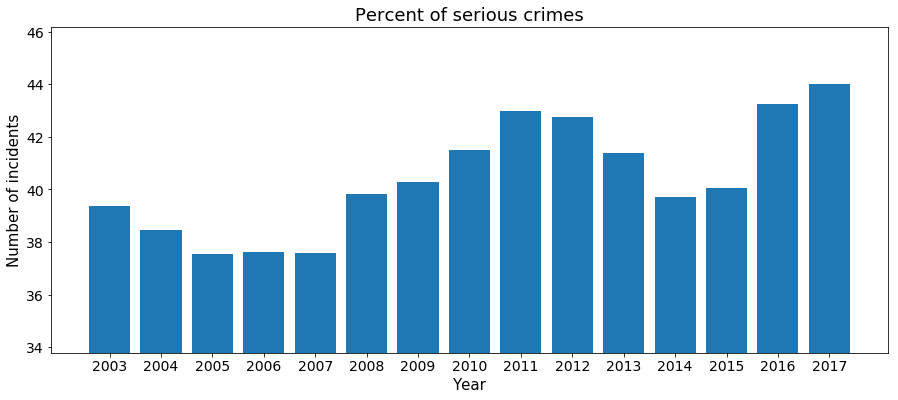

In [38]:
fig = plt.figure(figsize=(15, 6))
plt.bar(x=range(2003, 2018, 1), height=temp['Serious offense'] * 100, width=0.8, align='center')
plt.ylim(temp['Serious offense'].min() * 100 * 0.9)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of incidents', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(range(2003, 2018, 1), fontsize=14)
plt.title('Percent of serious crimes', fontsize=18);

### There is no obvious dependence. But in general proportion of serious crimes is increasing.

In [39]:
temp = df.merge(fbi_df, left_on='FBI Code', right_on='Code')[['Year', 'Description_y', 'ID']]
temp = temp.groupby(by=['Year', 'Description_y'])['ID'].count().reset_index()

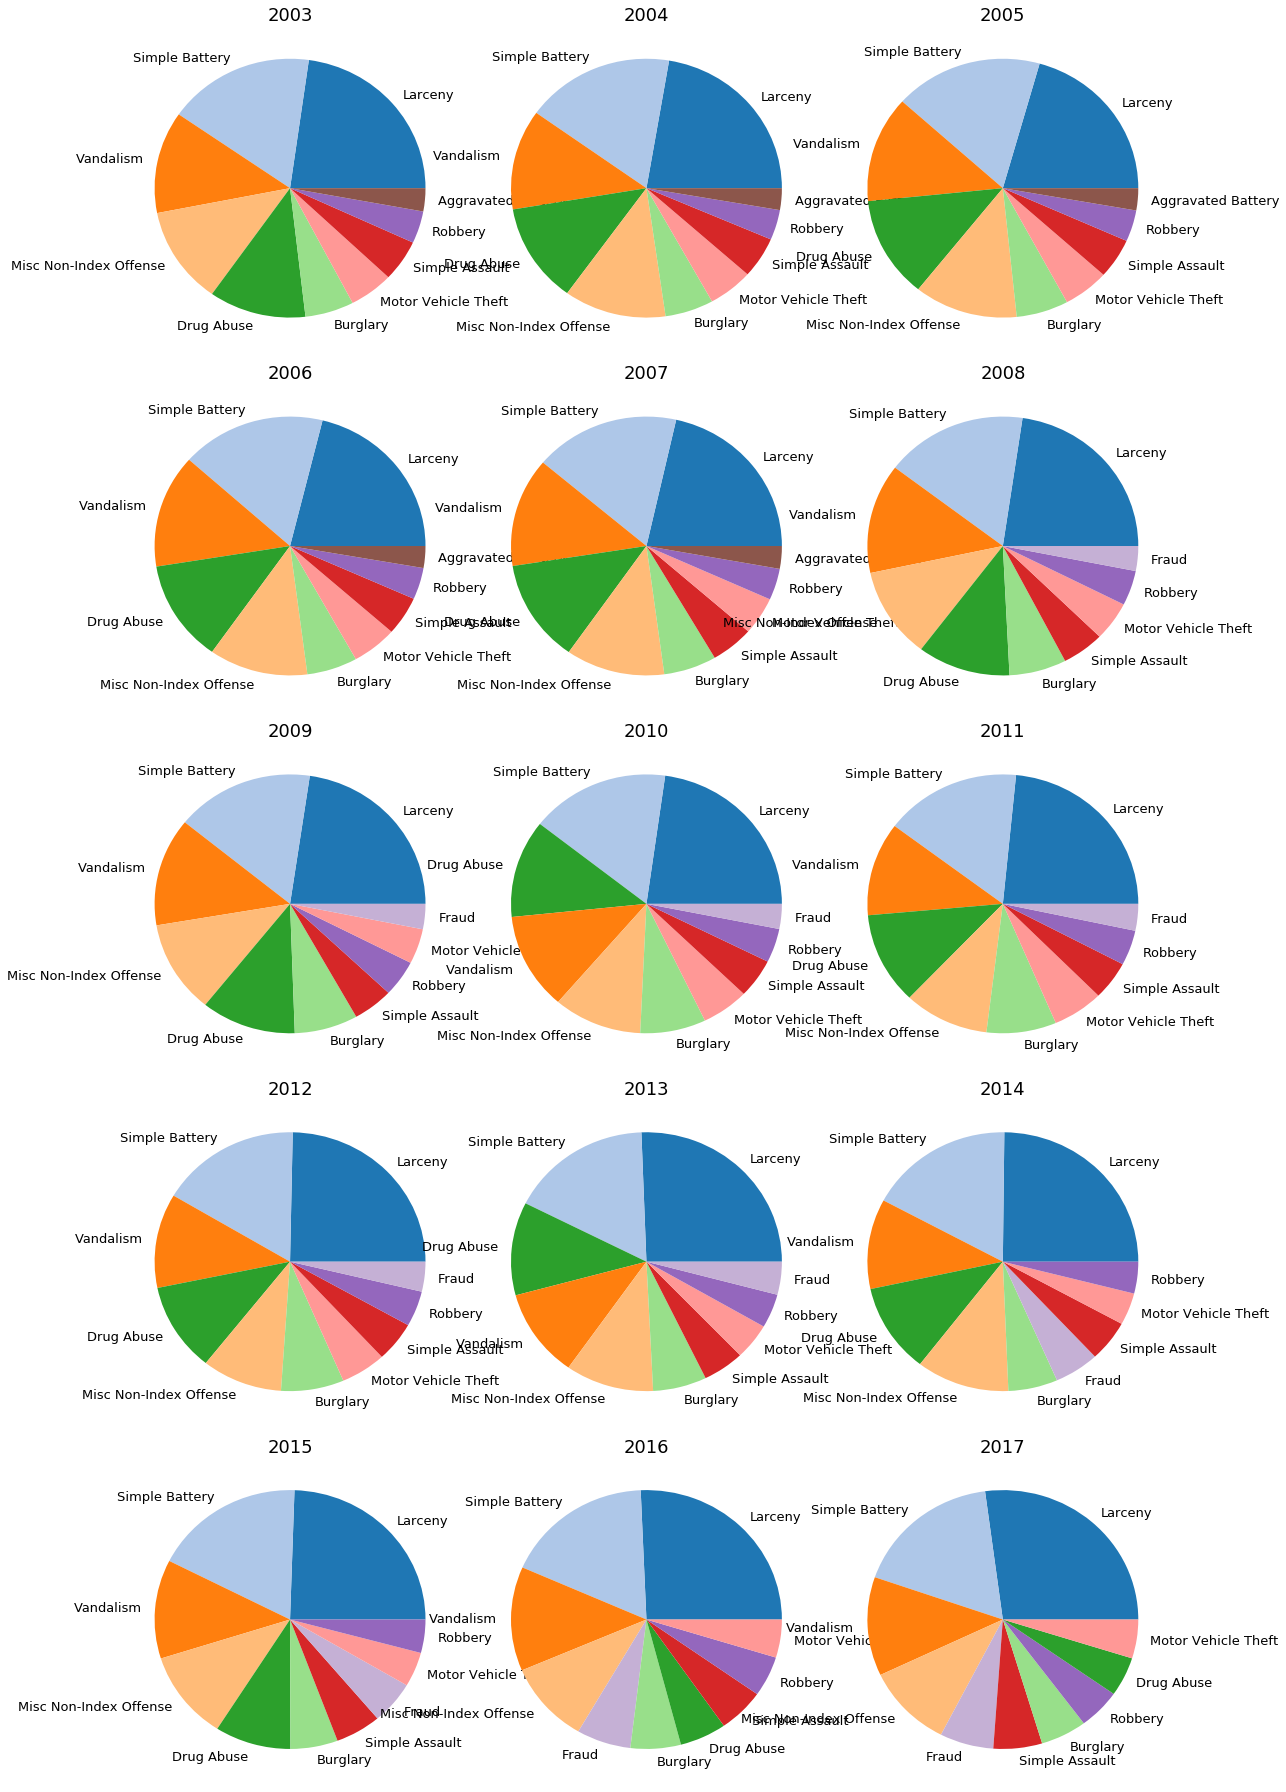

In [40]:
n = 3 # col
m = (14 - 1) // n + 1 # rows 14 is range of years
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 5))

for i, year in enumerate(range(2003, 2018, 1)):
    _temp = temp.loc[temp['Year'] == year].sort_values('ID', ascending=False).head(10)
    r, c = i // n, i % n
    ax = axes[r, c]
    wedges, texts = ax.pie(x=_temp['ID'], labels=_temp['Description_y'], 
           colors=[colrs[label] for label in _temp['Description_y']])
    [text.set_size(13) for text in texts]
    ax.set_title(year, size=18)

fig.tight_layout()
del _temp

### There is increment in larceny and fraud and decrement in drug abuse during years.